# Исследование объявлений о продаже квартир

## 1. Обзор данных

**Библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

**Таблицы**

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')

**Обзор**

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Что обработать

1. Данные в следующих столбцах нужно привести к целочисленному типу: 
- число парков в радиусе 3 км - не может быть 1,5 парка
- число водоёмов в радиусе 3 км - не может быть 1,5 водоема
- сколько дней было размещено объявление (от публикации до снятия) - сложно корректно интерпретировать 1.87 дня, да и вряд ли нам нужна такая точность
- число балконов - не может быть 1.5 балконов
- всего этажей в доме - не может быть 1.5 этажа
- цена на момент снятия с публикации - вряд ли нам нужна цена с точностью до копеек

2. Столбец 'first_day_exposition' содержит информацию о дате размещения в неудобном для работы виде. Нужно привести его к рабочему виду с помощью to_datetime()

3. Столбец 'is_apartment' стоит перевести в булев тип

4. Пропусков много и они в разных столбцах. Разебермся с каждым из них в отдельности в блоке предобработки. 

## 2. Предобработка

### Пропуски

#### Столбец ceiling_height - высота потолков

In [5]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Высоту потолков пользователь мог просто не указать: не хотел или не видел в этом необходимости (например подумал, что она везде стандартная). Пропусков в этом столбце очень много, поэтому удалять их мы точно не будем. Но и заменить на харакетрное значение (медиану или среднее) будет не совсем верным решением. Заменив 11 тысяч пропусков на одно единственное значение мы можем сильно исказить данные и это помешает дальнейшему исследованию. **Оставим этот столбец как есть.** 

#### Столбцы living_area и kitchen_area: жилая площадь и площадь кухни в кв.м.
Рассматриваем эти пропуски вместе, потому что их природа может быть одинаковой. Пользователь мог посчитать ненужным заполнять именно эти пункты, ведь самое главное - общая площадь. Попробуем разобраться - есть ли закономерность в их появлении. 


Что, если площадь кухни не указана там же, где и жилая площадь? А что, если площадь кухни и жилая площадь не указывается в квартирах со свободной планировкой или квартирах студиях (раз нет деления на комнаты то и нет данных по площадям кажой части квартиры?  

In [6]:
print('Пропусков в столбцах')
print('Площадь кухни: ', len(data[data['kitchen_area'].isna()]))
print('Жилая площадь: ', len(data[data['living_area'].isna()]))
print('Жилая площадь + площадь кухни:', len(data[(data['living_area'].isna()) & (data['kitchen_area'].isna())]))
print('Площадь кухни + свободная планировка: ', len(data[(data['kitchen_area'].isna()) & 
                                                 (data['open_plan'] == True)]))
print('Жилая площадь + свободная планировка: ', len(data[(data['living_area'].isna()) & 
                                                 (data['open_plan'] == True)]))
print('Площадь кухни + студия: ', len(data[(data['kitchen_area'].isna()) & 
                                                 (data['studio'] == True)]))
print('Жилая площадь + студия: ', len(data[(data['living_area'].isna()) & 
                                                 (data['studio'] == True)]))

Пропусков в столбцах
Площадь кухни:  2278
Жилая площадь:  1903
Жилая площадь + площадь кухни: 1464
Площадь кухни + свободная планировка:  67
Жилая площадь + свободная планировка:  5
Площадь кухни + студия:  149
Жилая площадь + студия:  10


Второе предположение точно не оправдалось. Первое предположение проявилось частично, но не настолько, чтобы помочь разобраться в природе появления пропусков. Значит, идем по классическому пути. Переменная количественная, поэтому заменяем пропуски на характерные значения. Но, есть нюанс: медиана здесь не сработает. Медиана может дать противоречивые данные. Например: общая площадь квартиры будет 20 кв.м, а жилая (заполненная по медиане) - 35 кв.м. В случае с площадью, как мне кажется, может быть справедливой следующая идея:

Значения доли площади кухни и жилой площади в общей площади квартиры в среднем будут находится в небольшом диапозоне значений. Соответственно, посчитав среднюю долю, мы сможем заполнить пропуски в каждом столбце на основании данных из столбца с общей площадью (она есть для всех объявлений). В таком случае у нас никогда не получится ситуации, что кухня больше, чем вся квартира. 

Найдем доли кухни и жилой площади и сразу округлим их двух знаков после запятой. 

In [7]:
data['living_area_part'] = data['living_area'] / data['total_area']
data['kitchen_area_part'] = data['kitchen_area'] / data['total_area']
data[['living_area_part','kitchen_area_part']] = data[['living_area_part','kitchen_area_part']].round(2)

<AxesSubplot:>

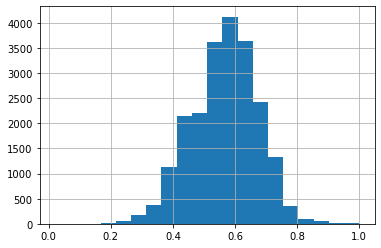

In [8]:
data['living_area_part'].hist(bins=20)

In [9]:
data['living_area_part'].describe()

count    21796.000000
mean         0.564745
std          0.105431
min          0.020000
25%          0.500000
50%          0.570000
75%          0.640000
max          1.000000
Name: living_area_part, dtype: float64

<AxesSubplot:>

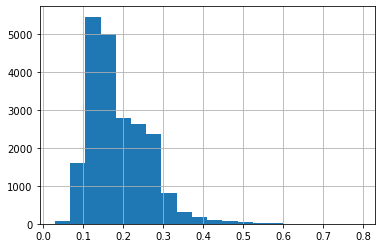

In [10]:
data['kitchen_area_part'].hist(bins=20)

In [11]:
data['kitchen_area_part'].describe()

count    21421.000000
mean         0.187321
std          0.073073
min          0.030000
25%          0.130000
50%          0.170000
75%          0.230000
max          0.790000
Name: kitchen_area_part, dtype: float64

И действительно: больше всего значений доли жилой площади находится в диапозоне от 0.4 до 0.8, а доли кухни - от 0.1 до 0.3. Возьмем медиану для каждого столбца и заполним пропуски, просто умножая нужную долю на total_area. Округлим значения до 1 знака после запятой. 

In [12]:
data['living_area'].fillna(data['living_area_part'].median() * data['total_area'], inplace=True)
data['kitchen_area'].fillna(data['kitchen_area_part'].median() * data['total_area'], inplace=True)
data[['living_area','kitchen_area']] = data[['living_area','kitchen_area']].round(1)

#### Столбец floors_total - общее количество этажей в доме.
Опять же, скорее всего пользователь просто забыл проставить это значения, либо (если эти данные автоматически подгружаются из какой-то базы) информации по конкретно этим домам не было. Посмотрим на эти строки

In [13]:
data[data['floors_total'].isna()].shape[0]

86

Переменная количественная, но брать среднее значения для нее тоже может оказаться ошибочным. Получится, что где-то квартира находится на 12 этаже, когда в доме всего 6. Строк с пропусками всего 86. Это достаточно мало и вряд ли повлияет на полноту информации. Поэтому просто избавимся от них. 

In [14]:
data.dropna(subset=['floors_total'], inplace=True)

#### Столбец is_apartment: является ли помещение нежилым.
В этом столбце всего 2775 строчек имеют указанное значение. Поскольку значения может быть всего два (Тру или Фолс), предполагаю, что все незаполенные значения - это False. Помещение не является апартаментами и этот пункт пользователь просто пропустил (для него это поле было вообще не актуальным). Значит ли это, что все указанные значения - это True?

In [15]:
print('Среди имеющихся значений:')
print('Значений False:', data.query('is_apartment == False')['is_apartment'].count())
print('Значений True:', data.query('is_apartment == True')['is_apartment'].count())

Среди имеющихся значений:
Значений False: 2725
Значений True: 50


Даже в заполненных ячейках значений True всего 50, так что скорее всего гипотеза верная. Заполним все пропуски значением False.

In [16]:
data['is_apartment'].fillna(False, inplace=True)

#### Столбец balcony - количество балконов
Скорее всего - здесь все просто: если число балконов не указано, то их просто нет. Пользователь пропустил это поле, не увидев смысла проставлять значение 0. Заменим все пропуски на 0.

In [17]:
data['balcony'].fillna(0, inplace=True)

#### Столбец locality_name - название населённого пункта
Вряд ли пропуск связан с ошибкой пользователя: адрес объекта - важная часть объявления. Учитывая то, что в большей части этих строчек расстояние до центра города не превышает 10км, могу предополжить, что это объекты в Питере для которых указали адрес, но не написали название города.  

Пропусков немного, но предлагаю не избавляться от них, а просто заменить на значение "Неизвестно".

In [18]:
data['locality_name'].fillna('Неизвестно', inplace=True)

 #### Столбец airports_nearest и cityCenters_nearest - расстояния до ближайшего аэропорта и центра города
 Судя по описанию задания - эти данные получены автоматически. Беглая проверка показала, что пропуски встречаются во всех строчках с конкретными населенными пунтками. Почему именно в них - предположить не могу. Пропусков в этих пункатах практически одинаковое количество (а еще - оно сходится с количеством пропусков в столбцах parks_around3000 и ponds_around3000. Есть ощущение, что это взаимосвязанные события. Может быть функцию показа этих значений в объявлении запустили только недавно и данные по старым объявлениям не были обновлены. 
 
Для заполнения пропусков можно было бы проверить расстояние на карте, но населенных пунктов (с пропусками значений в данных столбцах) очень много, чтобы делать это вручную. Заполнять их характерными значениями кажется неподходящей идеей: пропусков около 5 тысяч, и неверной заменой мы исказим данные для анализа. Я предлагаю оставить их как есть (а еще сообщить коллегам, что в этих населенных пунтках не указано расстояние до аэропорта и центра города). 

#### Столбцы parks_around3000 и ponds_around3000: наличие парка и пруда в радиусе 3 км
Здесь было бы логично предположить, что в пропущенных значениях должно быть 0. Раз значения нет, значит и парков(прудов) рядом просто нет. Заменим пропуски и там и там на нули. 

In [19]:
data['parks_around3000'].fillna(0, inplace=True)
data['ponds_around3000'].fillna(0, inplace=True)

#### Столбцы parks_nearests и ponds_nearests: расстояние до ближайшего парка и пруда
Самое простое предположение: расстояние до парка и пруда не указано, если парка и пруда в радиусе 3км просто нет. Проверим это:

In [20]:
print('Пропусков в столбце')
print('Расстояние до парка: ', len(data[data['parks_nearest'].isna()]))
print('Расстояние до парка, когда рядом нет парков: ', len(data[(data['parks_nearest'].isna()) & 
                                                               (data['parks_around3000'] == 0)]))

Пропусков в столбце
Расстояние до парка:  15568
Расстояние до парка, когда рядом нет парков:  15568


Точно! Проверим тоже самое для прудов

In [21]:
print('Пропусков в столбце')
print('Расстояние до пруда: ', len(data[data['ponds_nearest'].isna()]))
print('Расстояние до пруда, когда рядом нет парков: ', len(data[(data['ponds_nearest'].isna()) & 
                                                               (data['ponds_around3000'] == 0)]))

Пропусков в столбце
Расстояние до пруда:  14552
Расстояние до пруда, когда рядом нет парков:  14552


Логика пропусков выяснена. Что с этим делать? С одной стороны, если парка в радиусе 3 км нет, значит расстояние до ближайшего парка будет больше 3 км. То есть мы могли бы взять значение 3001 и в дальнейшем помнить - что именно оно означает.  

Однако, если данные понадобятся для анализа - у нас будет 14552 заполненных значения, которые исказят информацию очень сильно. **Предлагаю оставлять их как есть.** 

#### Столбец days_exposition: количество дней от публикации до снятия
Предположение простое: объявление сняли в тот же день, а значение '0' почему-то не проставляется. Попробуем проверить это, посмотрев, есть ли вообще строки со значением 0?

In [22]:
data.query('days_exposition == 0').shape[0]

0

Скорее всего - помещение купили в тот же день, а может быть объявление разместили, а затем сняли и разместили другое заново. Так или иначе - заполняем все нулями.  

In [23]:
data['days_exposition'].fillna(0, inplace=True)

Финально посмотрим на данные о фрейме, чтобы убедиться, что все ок. 

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          23613 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

### Названия населенных пунктов

Посмотрим - сколько значения вообще есть в этом столбце

In [25]:
data['locality_name'].nunique()

365

Значений много, поэтому исправить руками не выйдет. Посмторим на них визуально, а затем будем поэтапно приводить в порядок.

In [26]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Приведем все к нижнему регистру. 

In [27]:
data['locality_name'] = data['locality_name'].str.lower()

Заменим букву ё на е

In [28]:
data['locality_name'].replace('ё', 'е', regex=True, inplace=True)

Уберем из названий обозначения населенных пунктов: поселок, деревня, поселок городского типа, село, садовое товарищество, городской поселок, поселок станции, садоводческое некоммерческое товарищество, посёлок при железнодорожной станции, коттеджный поселок

In [29]:
locality_names_to_remove = ['деревня', 
                            'поселок городского типа', 
                            'садовое товарищество', 
                            'городской поселок', 
                            'поселок станции', 
                            'садоводческое некоммерческое товарищество', 
                            'поселок при железнодорожной станции', 
                            'коттеджный поселок',
                            'поселок',
                            'село']

In [30]:
for name_to_remove in locality_names_to_remove:
    data['locality_name'] = data['locality_name'].str.replace(name_to_remove, "")

In [31]:
data['locality_name'].unique()

array(['санкт-петербург', ' шушары', ' янино-1', ' парголово', ' мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', ' кудрово',
       'коммунар', 'колпино', ' красный бор', 'гатчина', ' федоровское',
       'выборг', 'кронштадт', 'кировск', ' новое девяткино',
       ' металлострой', ' лебяжье', ' сиверский', ' молодцово',
       ' кузьмоловский', ' новая ропша', 'павловск', ' пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       ' куттузи', ' аннино', ' ефимовский', ' плодовое', ' заклинье',
       ' торковичи', ' первомайское', 'красное ', ' понтонный',
       'сясьстрой', ' старая', ' лесколово', ' новый свет', 'сланцы',
       ' путилово', 'ивангород', 'мурино', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновый бор', ' оржицы', ' кальтино', 'кудрово',
       ' романовка', ' бугры', ' рощино', 'кириши', 'луга', 'волосово',
       'отрадное', ' павлово', ' оредеж', ' копорье', ' молодежное',
       'тихвин', ' победа', ' н

Осталось лишь убрать пробелы в начале строки

In [32]:
data['locality_name'] = data['locality_name'].str.lstrip()

In [33]:
data['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'федоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное ', 'понтонный', 'сясьстрой',
       'старая', 'лесколово', 'новый свет', 'сланцы', 'путилово',
       'ивангород', 'шлиссельбург', 'никольское', 'зеленогорск',
       'сосновый бор', 'оржицы', 'кальтино', 'романовка', 'бугры',
       'рощино', 'кириши', 'луга', 'волосово', 'отрадное', 'павлово',
       'оредеж', 'копорье', 'молодежное', 'тихвин', 'победа', 'нурма',
       'синявино', 'тосно', 'стрельна', 'бокситогорск', 'ал

Сделано!

### Замена типов данных

#### Float на Int
Заменить вещественный тип на целочисленные значения имеет смысл в следующих столбцах:
- last_price: зачем нам точность до копеек, когда речь идет о миллионах
- floors_total: этажей в доме не может быть 2.5
- balcony: в квартире не может быть 1.5 балкона
- ponds_around3000 и parks_around3000: не может быть 1.5 парка или пруда
- days_exposition: аналогично

In [34]:
data[['last_price', 
      'floors_total', 
      'balcony', 
      'days_exposition', 
      'ponds_around3000', 
      'parks_around3000']] = data[['last_price', 
      'floors_total', 
      'balcony', 
      'days_exposition', 
      'ponds_around3000', 
      'parks_around3000']].astype('int')

#### Obejct на Datetime
В одном из столбцов нам нужно привести дату в рабочий вид, чтобы затем работать с ней и получать разные данные. Это делают методом to_datetime().

In [35]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

### Дубликаты

In [36]:
data.duplicated().sum()

0

Повторяющихся строк нет

## 3. Расчёты

Данные предобработаны. Теперь нам нужно посчитать и добавить в таблицу:
- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры; варианты — первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей.

### Цена квадратного метра
Столбец 'last_price' делим на столбец 'total_area'. Сразу переведем в целый тип, чтобы не мешала дробная часть. 

In [37]:
data['square_meter_price'] = data['last_price'] / data['total_area']
data['square_meter_price'] = data['square_meter_price'].astype('int')

### День недели, месяц и год публикации объявления

#### День недели

In [38]:
data['day_of_week_exposition'] = data['first_day_exposition'].dt.weekday

#### Месяц

In [39]:
data['month_exposition'] = data['first_day_exposition'].dt.month

#### Год

In [40]:
data['year_exposition'] = data['first_day_exposition'].dt.year

### Этаж квартиры
Три варианта: первый, последний, другой. Напишем функцию, которая присваивает категорию этажа и применим ее ко всем строчкам, создав новый столбец. 

In [41]:
def floor_category_definder(row):
    if row['floor'] == 1:
        category = 'Первый'
    elif (row['floor'] != 1) & (row['floor'] == row['floors_total']):
        category = 'Последний'
    else:
        category = 'Другой'
    return category

In [42]:
data['floor_category'] = data.apply(floor_category_definder, axis=1)

## 4. Исследовательский анализ данных

### Площадь, цена, число комнат, высота потолков.

#### Площадь
Посмотрим общие данные о столбце, построим гистограмму и "ящик с усами", чтобы увидеть как распределились значения. 

In [43]:
data['total_area'].describe()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

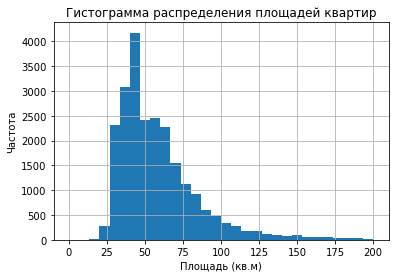

In [44]:
data['total_area'].hist(bins=30, range=(0,200))
plt.title('Гистограмма распределения площадей квартир')
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Частота');

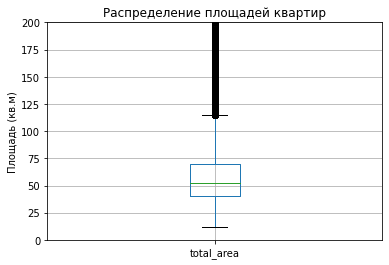

In [45]:
import matplotlib.pyplot as plt
plt.ylim(0,200)
data.boxplot(column='total_area')
plt.title('Распределение площадей квартир')
plt.ylabel('Площадь (кв.м)');

In [46]:
data.query('total_area > 500').shape[0]

7

#### Площадь: вывод
Большая часть значений площади лежит в диапозоне от 40 до 69 кв.м. Выглядит правдоподобно: средние квартиры обычно имеют площадь, которая попадает в этот рэнж. Статистически значимые значения заканчиваются на отметке где-то в 110 кв.м. Есть и квартиры гораздо большей площади, но они выходят за края усов. Квартир с площадью от 500 до 900 всего 7 штук. 
Резюмируем: данные выглядят правдоподобно, медиана не смещена и действительное отображает среднее значение по столбцу. 

#### Цена
Посмотрим общие данные о столбце, построим гистограмму и "ящик с усами", чтобы увидеть как распределились значения. 

In [47]:
data['last_price'].describe()

count    2.361300e+04
mean     6.540555e+06
std      1.090172e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Значения у стоимостей слишком большие, поэтому юпитер показывает их в экспоненциальном виде. Оценивать их в таком виде - не удобно. Отжерем нули, разделив все значения столбца на 1 миллион, и будем помнить, что стоимость у нас хранится в миллионах.  

In [48]:
data['last_price'] = data['last_price'] / 1000000
data['last_price'].describe()

count    23613.000000
mean         6.540555
std         10.901723
min          0.012190
25%          3.400000
50%          4.650000
75%          6.799000
max        763.000000
Name: last_price, dtype: float64

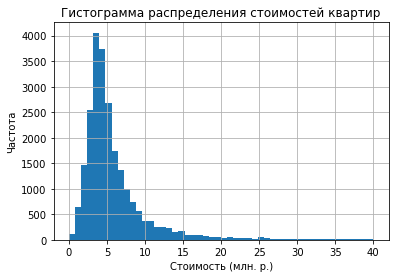

In [49]:
data['last_price'].hist(bins=50, range=(0,40))
plt.title('Гистограмма распределения стоимостей квартир')
plt.xlabel('Стоимость (млн. р.)')
plt.ylabel('Частота');

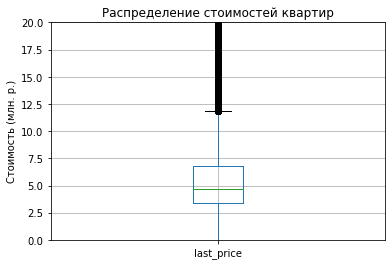

In [50]:
plt.ylim(0,20)
data.boxplot(column='last_price')
plt.title('Распределение стоимостей квартир')
plt.ylabel('Стоимость (млн. р.)');

#### Цена: вывод
Снова без сюрпризов: большая часть квартир плотненько лежит в диапозоне от 3.4 до 6.8 миллионов. Это сходится с реальностью. Гистограмма похожа на нормальное распределение. Хвост гистограммы уходит аж до 763 миллионов (видимо это та самая - 900 кв.м), но он незначительный и никак не смещяет средние значения. Статистически значимые значения заканчиваются на отметке где-то в 12 млн, что тоже похоже на правду. Квартиры дороже 12 млн покупают на-а-а-много реже. Данные выглядят правдоподобно.  

#### Число комнат
Посмотрим общие данные о столбце, построим гистограмму и "ящик с усами", чтобы увидеть как распределились значения. 

In [51]:
data['rooms'].describe()

count    23613.000000
mean         2.071147
std          1.078380
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Кстати - а что это за значения "0" комнат? Может быть это студии или квартиры со свободной планировкой?

In [52]:
print('Ноль комнат:', len(data.query('rooms == 0')))
print('Ноль комнат в квартирах со свободной планировкой:', len(data.query('rooms == 0 and open_plan == True')))
print('Ноль комнат в студиях:', len(data.query('rooms == 0 and studio == True')))
print('Студий со свободной планировкой:', len(data.query('studio == True and open_plan == True')))

Ноль комнат: 194
Ноль комнат в квартирах со свободной планировкой: 59
Ноль комнат в студиях: 135
Студий со свободной планировкой: 0


Так и есть: значение "ноль" команат - это не ошибка. Это либо студии, либо квартиры со свободной планировкой...и другого не дано. Таких значений немного, но это не совсем корректно, ведь при дальнейшем исследовании влияния количества комнат на цену, это может сказаться на результате. Давайте заменим их. 

Мы не можем точно сказать - сколько комнат в студиях и квартирах со свободной планировкой. Поэтому предлагаю заменить все нули на медиану столбца. 

In [53]:
data['rooms'].where(data['rooms'] > 0, 2, inplace=True)

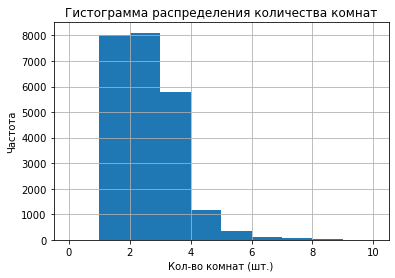

In [54]:
data['rooms'].hist(bins=10, range=(0,10))
plt.title('Гистограмма распределения количества комнат')
plt.xlabel('Кол-во комнат (шт.)')
plt.ylabel('Частота');

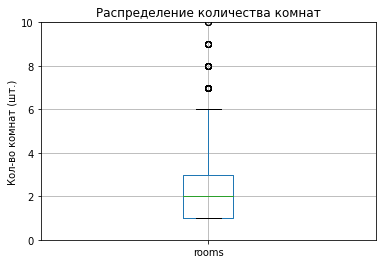

In [55]:
plt.ylim(0,10)
data.boxplot(column='rooms')
plt.title('Распределение количества комнат')
plt.ylabel('Кол-во комнат (шт.)');

#### Число команат: вывод
И здесь, за исключением ситуации с 0 комнатами, все в порядке. Большая часть квартир имеет от 1 до 3 комнат, третий квартиль заканчивается на значении 6 комнат. Хотя даже это уже редкость: есть ли у кого-то из знакомых такая квартира? Едва ли.  

Есть выборсы, но они не смещают сердние значения.  Данные выглядят правдоподобно.  

#### Высота потолков
Здесь мы вносили изменения во время преобработки. Сейчас выясним - какую роль они сыграли на информативности данных. Напомним, что там мы заполнили одним значением практически 11 тысяч пропусков. 

In [56]:
data['ceiling_height'].describe()

count    14495.000000
mean         2.771495
std          1.261445
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

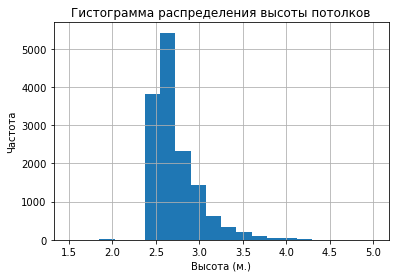

In [57]:
data['ceiling_height'].hist(bins=20, range=(1.5,5))
plt.title('Гистограмма распределения высоты потолков')
plt.xlabel('Высота (м.)')
plt.ylabel('Частота');

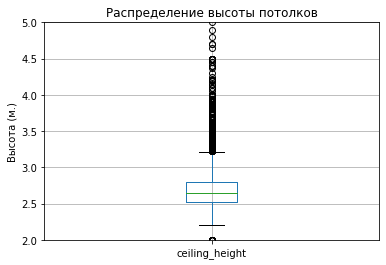

In [58]:
plt.ylim(2,5)
data.boxplot(column='ceiling_height')
plt.title('Распределение высоты потолков')
plt.ylabel('Высота (м.)');

#### Высота потолков: вывод
Распределение выглядит правдоподобно. Большая часть значений находится в диапозоне от 2.5 до 2.8 метра, что вполне соответствует реальности. Гистограмма похожа на нормальное распределение. 

### Время продажи квартиры

Задача: изучить время продажи квартиры. 
- построить гистограмму,
- посчитать среднее и медиану
- описать: сколько времени обычно занимает продажа
- ответить на вопроса: когда можно считать, что продажи прошли очень быстро, а когда необычно долго?
- убрать редкие и выбивающиеся значения
- описать, какие особенности обнаружены

In [59]:
data['days_exposition'].describe()

count    23613.000000
mean       156.586075
std        213.502550
min          0.000000
25%         22.000000
50%         73.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

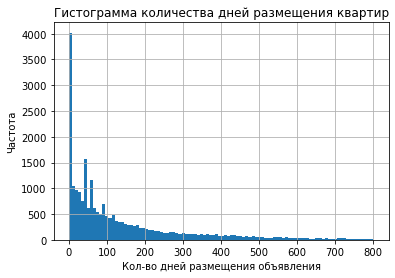

In [60]:
data['days_exposition'].hist(bins=100, range=(0,800))
plt.title('Гистограмма количества дней размещения квартир')
plt.xlabel('Кол-во дней размещения объявления')
plt.ylabel('Частота');

Гистограмма напоминает нормальное распредление за исключением нескольких пиков на конкрентых диапозонах. Самый большой пик - на значении 0. Причем 3200 таких значений мы заполнили самостоятельно во время предобработки данных. Гипотеза была в том, что значения NaN автоматически проставлялись в случае, когда публикация была снята в тот же день или сразу после публикации. 

Однако, пик поднимается до количества 4000. Это значит, что были такие строчки, где значение "0 дней" было и до замены пропусков. Значит, NaN проставляется не по этой причине: может быть это  ошибочные публикации, которые были не до конца заполнены или удалены моментально после. Так или иначе, они могут влиять на среднее значение и судя по гистограмме, их здесь быть не должно. Уберем их из выборки и вернем этот столбец в исходный вид. Пусть NaN отражает то, что объявление было с ошибкой. Обратимся к исходному фрейму  и заменим имеющийся столбец на исходный. 

In [61]:
data_original = pd.read_csv('real_estate_data.csv', sep='\t')
data_original.dropna(subset=['floors_total'])
data['days_exposition'] = data_original['days_exposition']

Теперь посмотрим еще раз и сделаем выводы

In [62]:
data['days_exposition'].describe()

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Text(0, 0.5, 'Частота')

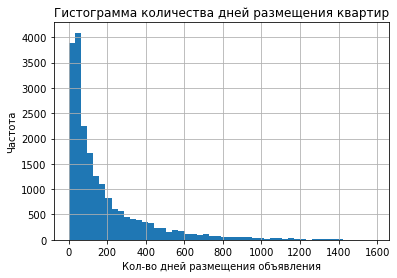

In [63]:
data['days_exposition'].hist(bins=50)
plt.title('Гистограмма количества дней размещения квартир')
plt.xlabel('Кол-во дней размещения объявления')
plt.ylabel('Частота')

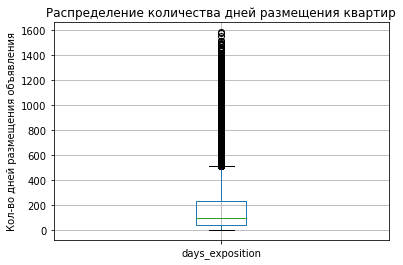

In [64]:
data.boxplot('days_exposition')
plt.title('Распределение количества дней размещения квартир')
plt.ylabel('Кол-во дней размещения объявления');

И отдельно только коробку с усами без выбросов

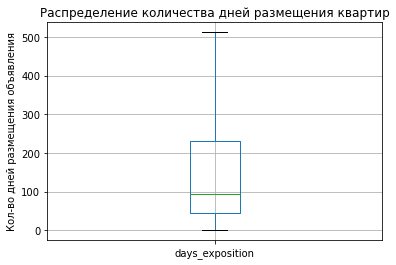

In [65]:
data.boxplot('days_exposition', showfliers=False)
plt.title('Распределение количества дней размещения квартир')
plt.ylabel('Кол-во дней размещения объявления');

#### Вывод
- построили гистограмму;
- посчитать среднее (190 дней) и медиану (103 дней) по продаже;
- выяснили, что обычно продажа занимает от 45 до 247 дней;
- выяснили, что можно считать продажу очень быстрой, если она случилась раньше 45 дней и необыно долго, если это случилось после 550 дней;

### Редкие и выбивающиеся значения

#### Площадь

<AxesSubplot:>

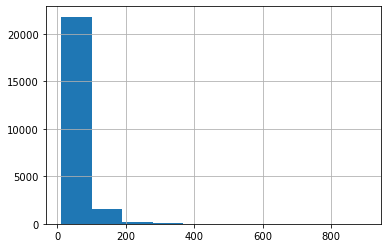

In [66]:
data['total_area'].hist()

<AxesSubplot:>

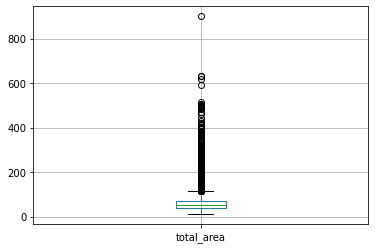

In [67]:
data.boxplot('total_area')

На общем плане гистограммы видно, что после 400 кв.м она сливается с нулем. Однако "ящик показывает, что там все еще есть несколько точек. А вот после где-то после 550 лежат лишь 3 значения. Нащупаем границу и избавимся от них. 

In [68]:
data.query('total_area > 550')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,living_area_part,kitchen_area_part,square_meter_price,day_of_week_exposition,month_exposition,year_exposition,floor_category
3117,19,140.0,631.0,2019-03-30,7,NaN,5,359.7,5,False,...,2,210.0,NaN,NaN,0.10,221870,5,3,2019,Последний
5358,20,65.0,590.0,2019-02-14,15,3.5,6,409.0,3,False,...,0,NaN,14.0,0.69,0.17,110169,3,2,2019,Другой
12859,20,140.0,631.2,2019-04-09,7,3.9,4,322.3,4,False,...,2,210.0,NaN,0.51,0.03,221799,1,4,2019,Последний
15651,20,300.0,618.0,2017-12-18,7,3.4,7,258.0,5,False,...,2,198.0,111.0,0.42,0.11,485436,0,12,2017,Другой
19540,8,420.0,900.0,2017-12-06,12,2.8,25,409.7,25,False,...,2,318.0,106.0,0.46,0.12,466666,2,12,2017,Последний


Так и есть, они после 550, удаляем. 

In [69]:
data = data.query('total_area < 550')

#### Цена

<AxesSubplot:>

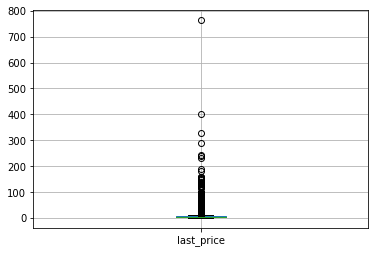

In [70]:
data.boxplot('last_price')

Аналогичная ситуация: после 300 - всего лишь 3 редких значения, одно из которых к тому же задрано очень сильно. Уберем их.

In [71]:
data = data.query('last_price < 300')

#### Число комнат

<AxesSubplot:>

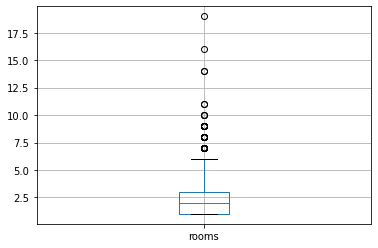

In [72]:
data.boxplot('rooms')

<AxesSubplot:>

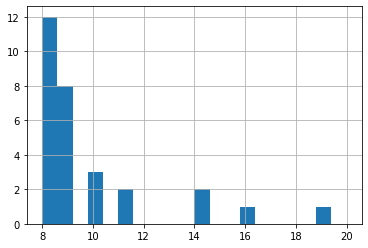

In [73]:
data['rooms'].hist(bins=20, range=(8,20))

То же самое и с комнатами, начиная с 9 комнат мы видим лишь редкие и очень высокие значения. Отрежем их. 

In [74]:
data = data.query('rooms < 9')

#### Высота потолков

<AxesSubplot:>

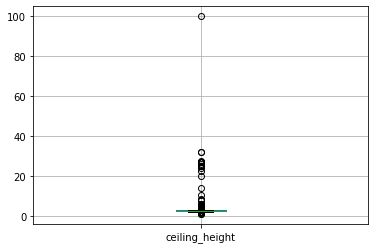

In [75]:
data.boxplot('ceiling_height')

Есть ощущение, что все значения после 20 могут быть ошибками (хотели написать 2.1, но забыли точку). Но, боюсь, что это может быть неверным предположением и исправив это вручную, исказим данные. Посмотрим - много ли там объявлений

In [76]:
len(data.query('ceiling_height > 20'))

22

Таких немного, поэтому предлагаю просто удалить их. 

In [77]:
data = data.query('ceiling_height < 20')

#### Время продажи квартиры

<AxesSubplot:>

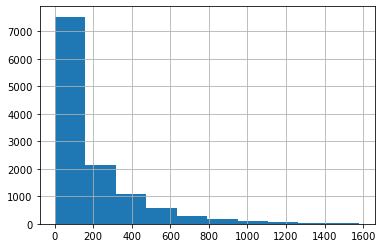

In [78]:
data['days_exposition'].hist()

<AxesSubplot:>

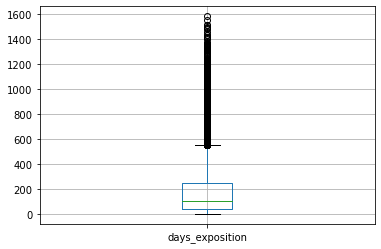

In [79]:
data.boxplot('days_exposition')

<AxesSubplot:>

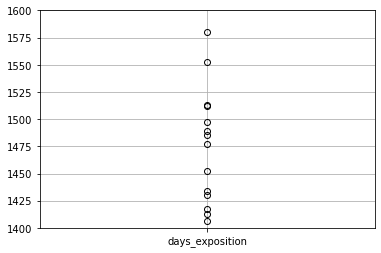

In [80]:
plt.ylim(1400,1600)
data.boxplot('days_exposition')

Значений, которые выбиваются прямо таки резко, нет. "Колбаса" боксплота лишь немного редеет после 1500, но и в диапозоне от 1400 до 1600 не наблюдается резко оторванных значений. Предлагаю этот столбец оставить как есть. 

## 5. Анализ

### Факты влияющие на стоимость квартиры
Задача: выяснить какие факторы больше всего влияют на стоимость квартиры. 
1. изучить: зависит ли цена от площади, числа комнат, этажа (первого или последнего), удалённости от центра. 
2. изучить зависимость от даты размещения: дня недели, месяца и года. 

#### Часть 1: цена, число комнат, этаж, удаленность от центра
Чтобы увидеть возможную зависимость, нам нужно построить матрицу корреляции. Все данные для нее у нас готовы, кроме столбца 'floor_category': там хранятся категореальные переменные, а по ним корреляция посчитана не будет. Чтобы учесть их тоже, создадим еще один столбец, содержащий булевый тип. Если этаж первый или последний - True, иначе - False. И после этого построим матрицу. 

In [81]:
data['floor_category_id'] = (data['floor_category'] == 'Первый') | (data['floor_category'] == 'Последний')
data[['last_price','total_area', 'rooms', 'floor_category_id', 'cityCenters_nearest']].corr()

,last_price,total_area,rooms,floor_category_id,cityCenters_nearest
last_price,1.000000,0.715896,0.414188,-0.039281,-0.253260
total_area,0.715896,1.000000,0.757171,-0.000200,-0.245986
rooms,0.414188,0.757171,1.000000,0.057901,-0.192532
floor_category_id,-0.039281,-0.000200,0.057901,1.000000,0.052743
cityCenters_nearest,-0.253260,-0.245986,-0.192532,0.052743,1.000000


Посмотрим детальнее столбцы с наибольшими коэффициентами корреляции: площадь и кол-во комнат.

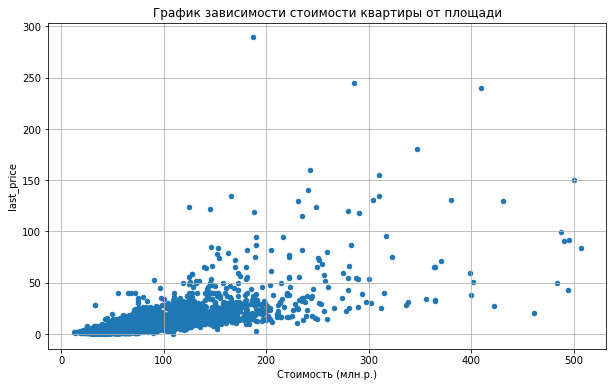

In [82]:
data.plot(x='total_area', 
          y='last_price', 
          kind='scatter', 
          grid=True, 
          figsize=(10,6))
plt.title('График зависимости стоимости квартиры от площади')
plt.xlabel('Площадь (кв.м.)')
plt.xlabel('Стоимость (млн.р.)');

Видно, что при площади от 0 до 20 точки лежат толстой линией, а дальше начинается разброс. Скорее всего, дело в том, что начиная с определнного момента площадь начинает влиять на стоимость все меньше и меньше.  

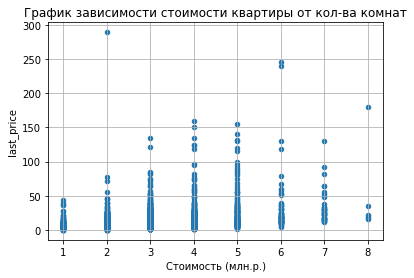

In [83]:
data.plot(x='rooms', 
          y='last_price', 
          grid=True,
          kind='scatter')
plt.title('График зависимости стоимости квартиры от кол-ва комнат')
plt.xlabel('Кол-во комнат')
plt.xlabel('Стоимость (млн.р.)');

С количеством комнат все не так однозначно. С одной стороны, с увеличением количества комнат точки начинают появляться все выше. При этом, нижняя граница вверх не поднимается. Это подтверждает невысокий коэффициент корреляции. 

#### Часть 1: Вывод
Заметная корреляция обнаружена только между ценой и площадью квартиры: 0.73. Это подтверждает вполне очевидное интуитивное наблюдение: чем больше площадь, тем дороже квартира. 

Количество комнат показывает меньший коэффицент - 0.42. Умеренно, но немного. При этом, куда более заметная (и очень логичная) корреляция наблюдаяется между количеством комнат и площадью квартиры. Это тоже очень логично. 

Расстояние от центра коррелирует со стоимостью довольно слабо, а расположение квартиры на первом или последнем этаже вообще не влияет на стоимость. 

#### Часть 2: дата размещения (день недели, месяц, год)
Для этого исследования нам снова нужно внести небольшие изменения. Мы создали столбцы с днем недели и месяцем размещения, которые содержат названия. Нам же нужны такие, которые содержат числовое выражение. Заменим их и снова построим матрицу корреляции

In [84]:
data['day_of_week_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month

In [85]:
data[['last_price', 'day_of_week_exposition', 'month_exposition', 'year_exposition']].corr()

,last_price,day_of_week_exposition,month_exposition,year_exposition
last_price,1.000000,-0.011804,0.000843,-0.065655
day_of_week_exposition,-0.011804,1.000000,-0.007945,-0.003289
month_exposition,0.000843,-0.007945,1.000000,-0.301114
year_exposition,-0.065655,-0.003289,-0.301114,1.000000


#### Часть 2: Вывод
Заметной корреляции не обнаружено ни с одним столбцом. Ни день недели, ни месяц ни год не влияют на цену продажи хоть сколь-нибудь заметно. 

### Исследование населенных пунктов

Задачи: 
- Выбрать 10 населённых пунктов с наибольшим числом объявлений
- Посчитать среднюю цену квадратного метра в этих населённых пунктах. 
- Выделить среди них населённые пункты с самой высокой и низкой стоимостью жилья. 

Сгруппируем данные по населенным пунктам с помощью  pivot_table: сделаем столбец с количеством объявлений и средней ценой кв.м. Оставим только 10 и отсортируем по убыванию. Дополнительно, чисто косметически, переназовем колонки и избавимся от кучи знаков после запятой в столбце  square_meter_price

In [86]:
data_locality = data.pivot_table(index='locality_name', 
                                 values='square_meter_price', 
                                 aggfunc=['mean', 'count'])

In [87]:
data_locality.columns = ['square_meter_price', 'count']
data_locality['square_meter_price'] = data_locality['square_meter_price'].astype('int')

In [88]:
data_locality = data_locality.sort_values(by='count', ascending=False).head(10).reset_index()

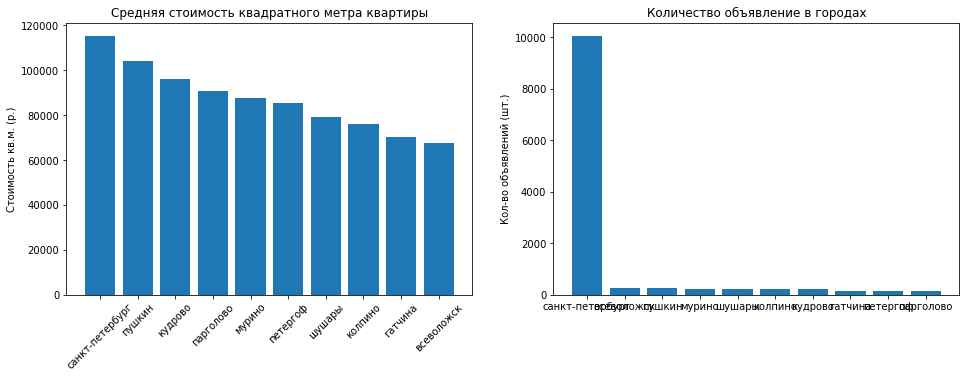

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

data_locality = data_locality.sort_values(by='square_meter_price', ascending=False)
ax1.bar(data_locality['locality_name'], data_locality['square_meter_price'])
ax1.set_title('Средняя стоимость квадратного метра квартиры')
ax1.set_ylabel('Стоимость кв.м. (р.)')
ax1.tick_params(axis='x', labelrotation=45)

data_locality = data_locality.sort_values(by='count', ascending=False)
ax2.bar(data_locality['locality_name'], data_locality['count'])
ax2.set_title('Количество объявление в городах')
ax2.set_ylabel('Кол-во объявлений (шт.)')
ax1.tick_params(axis='x', labelrotation=45);

#### Вывод
Выделили 10 населенных пунктов с наибольшим количеством объявлений и посчитали по каждому из них среднюю цену квадратного метра. Самый дорогой квадратный метр - в Питере, а самый дешевый - во Всеволжске. 

### Центр Питера

Наша задача - изучить предложения квартир в центре Санкт-Петербурге. Нам нужно выяснить - какая область входит в центр, а затем выделить сегмент квартир в центре и проанализировать их. 

Шаги: 
1. Создаем столбец с расстоянием до центра в километрах, округляя до целых значений.
2. Считаем среднюю цену для каждого километра.
3. Строим график, который показывает как цена зависит от удалённости от центра.
4. Определяем границу центра: где график сильно меняется — это и будет центральная зона.
5. Выделяем сегмент квартир в центре
6. Анализируем для сегмента параметры: площадь, цена, число комнат, высота потолков.
7. Ищем факторы, который влияют на стоимость квартиры: число комнат, этаж, удалённость от центра, дата размещения объявления.
8. Делаем вывод: отличается ли это от общих выводов. 

#### Шаг 1
Мы не избавились от пропусков в столбце 'cityCenters_nearest', потому как замена может привести к искажению данных. Пропусков в этом столбце довольно много, но для этого исследования нам все же придется от них избавиться. Создадим отдельный фрейм и проведем исследование с ним. Сделаем столбец с расстоянием в километрах (в целых числах),

In [90]:
data_for_center = data
data_for_center.dropna(subset=['cityCenters_nearest'], inplace=True)
data_for_center['cityCenters_nearest_km'] = data_for_center['cityCenters_nearest'] / 1000
data_for_center['cityCenters_nearest_km'] = data_for_center['cityCenters_nearest_km'].astype('int')

#### Шаг 2-3
Считаем среднюю цену для каждого расстояния и строим график. Напомним, что цена указана в миллионах.

In [91]:
data_for_center_stat = data_for_center.pivot_table(index='cityCenters_nearest_km', 
                            values='last_price', 
                            aggfunc='mean')

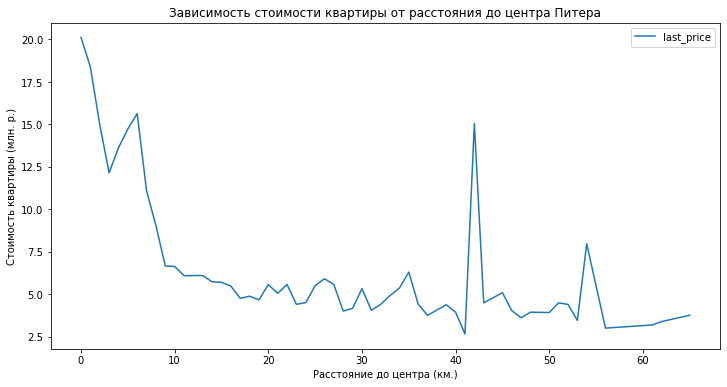

In [92]:
data_for_center_stat.plot(y='last_price', figsize=(12,6))
plt.title('Зависимость стоимости квартиры от расстояния до центра Питера')
plt.xlabel('Расстояние до центра (км.)')
plt.ylabel('Стоимость квартиры (млн. р.)');

#### Шаг 4-5
Определяем центр: видим, что где-то на отметке в 9км цена начинает стремительно ползти вверх. Скорее всего здесь и начинается граница центра города. Приблизим график, чтобы найти точное значение, с которого начинается подъем, а затем выделим весь сегмент квартир, находящихся в центре в отдельный фрейм, чтобы продолжить с ним работу. 

p.s. а еще - видны очень необычные пики на значениях около 40 и 55 км

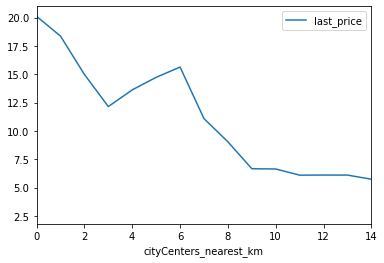

In [93]:
data_for_center_stat.plot(y='last_price', xlim=(0,14));

In [94]:
data_only_center = data_for_center.query('cityCenters_nearest_km < 9')

#### Шаг 6: площадь
Проанализируем параметры: площадь, цена, число комнат, высота потолков.

In [95]:
data_only_center['total_area'].describe()

count    2854.000000
mean       89.094660
std        53.762227
min        12.000000
25%        55.000000
50%        75.850000
75%       107.000000
max       507.000000
Name: total_area, dtype: float64

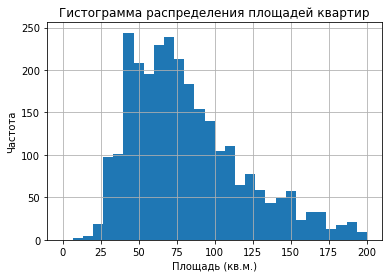

In [96]:
data_only_center['total_area'].hist(range=(0,200), bins=30)
plt.title('Гистограмма распределения площадей квартир')
plt.xlabel('Площадь (кв.м.)')
plt.ylabel('Частота');

Площадь квартир в центре Питера в среднем больше, чем по всей выборке: медианное значение отличается ( в большую сторону) аж на 23 квадратных метра. Большая часть значений лежит в диапозоне от 51 до 100 кв.м. Это больше, чем аналогичный рэндж по всей выборке. 

#### Шаг 6: цена

In [97]:
data_only_center['last_price'].describe()

count    2854.000000
mean       13.413352
std        16.833808
min         1.600000
25%         6.390000
50%         8.900000
75%        13.548744
max       289.238400
Name: last_price, dtype: float64

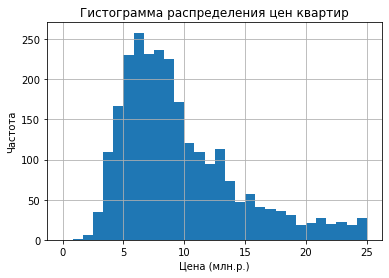

In [98]:
data_only_center['last_price'].hist(range=(0,25), bins=30)
plt.title('Гистограмма распределения цен квартир')
plt.xlabel('Цена (млн.р.)')
plt.ylabel('Частота');

Тоже самое происходит и с ценой. В центре города цены на жилье гораздо выше, чем в среднем по всей выборке. Медианная стоимость отличается практически в 2 раза! Большая часть значений так же лежит в диапозоне более высоких цен. Это хорошо видно на гистограмме. Пик по всем объявлениям находится в диапозоне от 0 до 5, а пик по объявлениям из центра города - между 5 и 10. 

#### Шаг 6: комнаты и высота потолков

In [99]:
data_only_center['rooms'].describe()

count    2854.000000
mean        2.768746
std         1.294299
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: rooms, dtype: float64

In [100]:
data_only_center['ceiling_height'].describe()

count    2854.000000
mean        3.042624
std         0.375140
min         2.000000
25%         2.800000
50%         3.000000
75%         3.200000
max         6.000000
Name: ceiling_height, dtype: float64

Все то же самое произошло с количеством комнат и высотой потолков. В квартирах в центре в среднем на одну команту больше, а потолки на 35 сантиметров выше.  

#### Шаг 7
Теперь попробуем выяснить, влияют ли на стоимость квартиры площадь, число комнат, этаж, удалённость от центра и дата размещения объявления. Для этого выделим только нужные нам столбцы и поработаем с ними. В одном фрейме будет все (что нам нужно) кроме параметров даты, а во втором - только параметры даты.

In [101]:
data_only_center_small = data_only_center[['last_price',
                                           'total_area',
                                           'rooms', 
                                           'floor', 
                                           'cityCenters_nearest_km']]

data_only_center_date = data_only_center[['last_price',
                                          'day_of_week_exposition', 
                                          'month_exposition', 
                                          'year_exposition']]

Начнем с первого фрейма: посторим матрицу корреляции и матрицу диаграмм рассеяния

In [102]:
data_only_center_small.corr()

,last_price,total_area,rooms,floor,cityCenters_nearest_km
last_price,1.000000,0.686390,0.381705,0.091517,-0.116097
total_area,0.686390,1.000000,0.748209,0.078745,-0.188470
rooms,0.381705,0.748209,1.000000,-0.071135,-0.240299
floor,0.091517,0.078745,-0.071135,1.000000,0.279868
cityCenters_nearest_km,-0.116097,-0.188470,-0.240299,0.279868,1.000000


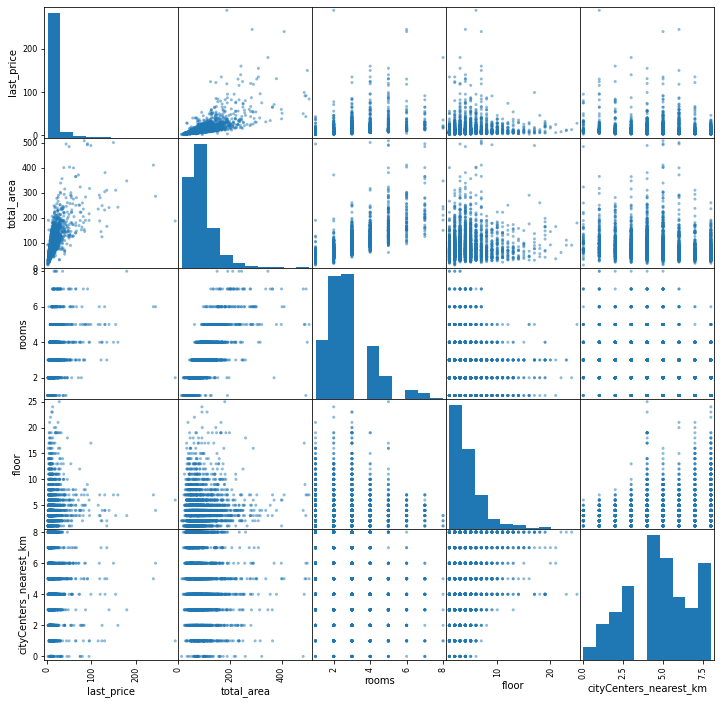

In [103]:
pd.plotting.scatter_matrix(data_only_center_small, figsize=(12,12))
pass

Здесь без сюрпризов: коэффициенты корреляции очень похожи на те, что мы рассчитали по всей выборке. Заметная корреляция наблюдается с площадью квартиры - 0.68. Это значение можно наблюдать на диаграмме рассеяния: до определенного момента площадь растет вместе с ценой, но затем точки начианают разлетаться в разные стороны. Судя по всему, начиная с определенного момента на стоимость начинают сильнее влиять и другие факторы. 

Теперь проверим возможное влияние даты на стоимость квартиры. 

In [104]:
data_only_center_date.corr()

,last_price,day_of_week_exposition,month_exposition,year_exposition
last_price,1.000000,-0.000903,-0.012433,-0.083622
day_of_week_exposition,-0.000903,1.000000,0.018116,-0.001743
month_exposition,-0.012433,0.018116,1.000000,-0.264734
year_exposition,-0.083622,-0.001743,-0.264734,1.000000


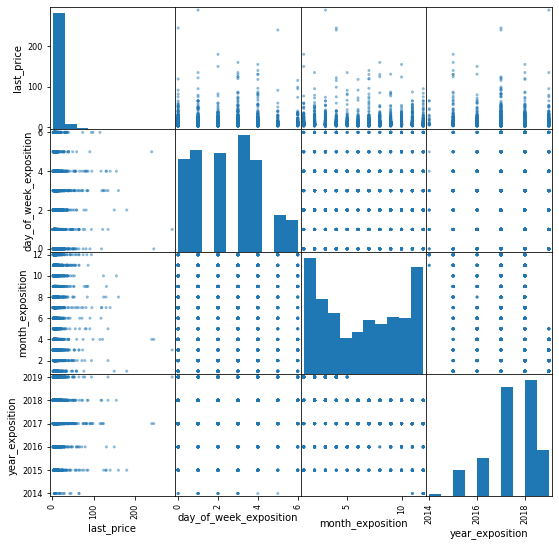

In [105]:
pd.plotting.scatter_matrix(data_only_center_date, figsize=(9,9)) 
pass

С компонентами даты все то же самое. Ни день, ни месяц, ни год публикации не оказывают хоть сколь-нибудь заметного влияния на стоимость. Это хорошо видно на диаграммах и просто по коэффициентам корреляции. 

#### Вывод
Мы выделили среди всех объявлений те, что располагаются в центре города и проанализировали только их. Площадь квартиры, цена, количество комнат и высота потолков выросла по сравнению с аналогичным анализом по всей выборке объявлений. Это подчиняется интуитивной логике: квартиры в центре скорее всего больше и дороже. 

Одновременно с этим мы попробовали найти факторы, влияющие на стоимость квартиры в центре, но выводы не изменились: заметное влияние оказывает только площадь квартиры и совсем немного - количество комнат. 

## Общий вывод

1. Мы предобработали данные с архивом объявлений о продаже квартир в Санкт-Петербурег и соседних населенных пунктах за несколько лет. 

- Обработали пропуски
- Заменили типы данных
- Рассчитали и добавили дополнительные параметры в таблицу
- Обработали строковый столбец с названиями населенных пунктов, чтобы они не дублировали друг друга

2. Затем - провели анализ, чтобы найти параметры, помогающие определить рыночную стоимость недвижимости. Проверили влияние на цену квартиры ее площади, числа комнат, высоты потолков и удаленности от центра. 

3. Детально изучили время продажи квартиры. Скорее всего вы продадите ее через 103 дня после размещения объявления. Большая часть значений попадает в диапозон от 45 до 247 дней. 

4. Удалили редкие значения в столбцах (площадь, цена, число комнта, время продажи), чтобы избежать их влияния на коэффициент корреляции

4. Провели анализ находящихся в центре города. Параметры площади, количества комнат, стоимости и высоты потолков для них получились выше, чем в общей выборке. Однако проверка влияния этих параметров на цену не показала ничего нового. 

**Итог**: на стоимость квартиры заметно влияет ее **площадь** (коэф. корел. 0.73) и **количество комнат** (0.42). Предлагаю коллегам взять эти параметры для оценки рыночной стоимости квартиры. 
